In [268]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

from crepes import ConformalRegressor, ConformalPredictiveSystem

from crepes.fillings import (sigma_variance, 
                             sigma_variance_oob,
                             sigma_knn,
                             binning)

In [269]:
train = pd.read_csv('train_prep_cmaps.csv').drop('Unnamed: 0', axis=1)
cal = pd.read_csv('calib_prep_cmaps.csv').drop("Unnamed: 0", axis=1)
test = pd.read_csv('test_prep_cmap.csv').drop("Unnamed: 0", axis=1)

In [270]:
train.head()

,engine,cycle,setting_1,setting_2,(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Bypass Ratio),(Bleed Enthalpy),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,125
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,125
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,125
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,125
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,125


In [271]:
test = test.drop(['engine'], axis=1)
train = train.drop(['engine'], axis=1)
cal = cal.drop(['engine'], axis=1)

In [272]:
X_train = train.drop('RUL', axis=1)
y_train = train['RUL']
X_test = test.drop('RUL', axis=1)
y_test = test['RUL']
X_cal = cal.drop('RUL', axis=1)
y_cal = cal['RUL']

print(X_train.shape)
print(X_test.shape)
print(X_cal.shape)

(16138, 17)
(2251, 17)
(2242, 17)


In [273]:
cr_std = ConformalRegressor()

In [274]:
display(cr_std)

ConformalRegressor(fitted=False)

In [275]:
learner_prop = RandomForestRegressor(n_jobs=-1, n_estimators=500) 

learner_prop.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1)

In [276]:
y_hat_cal = learner_prop.predict(X_cal)

residuals_cal = y_cal - y_hat_cal

cr_std.fit(residuals=residuals_cal)

ConformalRegressor(fitted=True, normalized=False, mondrian=False)

In [277]:
y_hat_test = learner_prop.predict(X_test)

intervals = cr_std.predict(y_hat=y_hat_test, confidence=0.99)

display(intervals)

array([[ 69.06 , 179.836],
       [ 69.386, 180.162],
       [ 69.392, 180.168],
       ...,
       [-50.232,  60.544],
       [-52.352,  58.424],
       [-52.59 ,  58.186]])

In [278]:
def sigma_variance(X, learner, beta=1.0):
    if hasattr(learner, 'estimators_'):
        y_pred = np.array([tree.predict(X) for tree in learner.estimators_])
        return np.var(y_pred, axis=0) + beta
    else:
        return np.var(learner.predict(X)) + beta


In [279]:
intervals_std = cr_std.predict(y_hat=y_hat_test, y_min=0, y_max=1)

display(intervals_std)

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [280]:
sigmas_cal_knn = sigma_knn(X=X_cal, residuals=residuals_cal)

cr_norm_knn = ConformalRegressor()

cr_norm_knn.fit(residuals=residuals_cal, sigmas=sigmas_cal_knn)

display(cr_norm_knn)

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

In [281]:
sigmas_test_knn = sigma_knn(X=X_cal, residuals=residuals_cal, X_test=X_test)

intervals_norm_knn = cr_norm_knn.predict(y_hat=y_hat_test, 
                                         sigmas=sigmas_test_knn,
                                         y_min=0, y_max=1)

display(intervals_norm_knn)

array([[1.        , 1.        ],
       [1.        , 1.        ],
       [1.        , 1.        ],
       ...,
       [0.52649891, 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

In [282]:
sigmas_cal_var = sigma_variance(X=X_cal, learner=learner_prop)


cr_norm_var = ConformalRegressor()

cr_norm_var.fit(residuals=residuals_cal, sigmas=sigmas_cal_var)

display(cr_norm_var)

C:\Users\R\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\R\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\R\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\R\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Decision

ConformalRegressor(fitted=True, normalized=True, mondrian=False)

In [283]:
sigmas_test_var = sigma_variance(X=X_test, learner=learner_prop)



intervals_norm_var = cr_norm_var.predict(y_hat=y_hat_test, 
                                         sigmas=sigmas_test_var, 
                                         y_min=0, y_max=1)

display(intervals_norm_var)

C:\Users\R\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\R\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\R\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\R\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Decision

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       ...,
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [284]:
bins_cal, bin_thresholds = binning(values=sigmas_cal_knn, bins=20)

cr_mond = ConformalRegressor()

cr_mond.fit(residuals=residuals_cal, bins=bins_cal)

display(cr_mond)

ConformalRegressor(fitted=True, normalized=False, mondrian=True)

In [285]:
bins_test = binning(values=sigmas_test_knn, bins=bin_thresholds)

In [286]:
intervals_mond = cr_mond.predict(y_hat=y_hat_test, bins=bins_test, 
                                         y_min=0, y_max=1)

display(intervals_mond)

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [287]:
learner_full = RandomForestRegressor(n_jobs=-1, n_estimators=500, 
                                     oob_score=True)

learner_full.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, n_jobs=-1, oob_score=True)

In [288]:
oob_predictions = learner_full.oob_prediction_

residuals_oob = y_train - oob_predictions

In [289]:
cr_std_oob = ConformalRegressor()

cr_std_oob.fit(residuals=residuals_oob)

ConformalRegressor(fitted=True, normalized=False, mondrian=False)

In [290]:
y_hat_full = learner_full.predict(X_test)

intervals_std_oob = cr_std_oob.predict(y_hat=y_hat_full, y_min=0, y_max=1)

display(intervals_std_oob)

array([[1., 1.],
       [1., 1.],
       [1., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [291]:
from sklearn.tree import DecisionTreeRegressor

def decision_tree(X_train, y_train, X_test):
  dt = DecisionTreeRegressor(max_depth=5)
  model = dt.fit(X_train, y_train)
  y_pred = dt.predict(X_test)
  # rmse = mean_squared_error(y_test,y_pred,squared=False)  

  return model, y_pred

In [292]:
from sklearn.ensemble import GradientBoostingRegressor

def gradient_boost(X_train, y_train, X_test):
  gb = GradientBoostingRegressor(max_depth=5)
  model = gb.fit(X_train, y_train)
  y_pred = gb.predict(X_test)
  # rmse = mean_squared_error(y_test,y_pred,squared=False)

  return model, y_pred

In [293]:
from sklearn.ensemble import RandomForestRegressor


def random_forest(X_train, y_train, X_test):
  regr = RandomForestRegressor(max_depth=2, random_state=0, n_jobs = -1)
  model = regr.fit(X_train, y_train)

  return model

In [294]:
from sklearn.svm import SVR
def svr(X_train, y_train, X_test):
  svr = SVR(kernel="rbf", C=100, gamma=0.5, epsilon=0.01).fit(X_train, y_train)
  return svr

In [295]:
import matplotlib.pyplot as plt

def plot_without_cp(y_test, y_pred):
  x = np.arange(1,len(y_pred)+1)

  plt.figure(figsize=(18,6))

  plt.plot(x,y_pred)
  plt.plot(x,y_test)
  plt.xlabel('test sample')
  plt.ylabel('RUL')
  plt.title('Predictive maintenance RUL of samples')
  plt.legend(["prediction","true"])
  plt.grid(True)
  plt.show()

In [296]:
def plot_with_cp(y_test, y_pred, y_pis, confidence):
  x = np.arange(1,len(y_pred)+1)

  plt.figure(figsize=(18,6))

  plt.plot(x,y_pred, linewidth=1.5)
  plt.plot(x,y_test, linewidth=1.3)

  plt.fill_between(x, y_pis[:,0].flatten(), y_pis[:,1].flatten(), alpha=0.2, color='tab:green', linewidth=3)

  plt.xlabel('test sample')
  plt.ylabel('RUL')
  plt.title('Predictive maintenance RUL of samples with confidence of ' + confidence +'%')
  plt.legend(["prediction","true",confidence + "% confidence interval"])
  plt.grid(True)
  plt.show()

In [297]:
from crepes import ConformalRegressor, ConformalPredictiveSystem

def conformal_prediction(model, a, X_train, y_train, X_test):
    crep = ConformalRegressor()
    cr_mond = ConformalRegressor()
    cr_mond.fit(residuals=residuals_cal, bins=bins_cal)
    display(cr_mond)

In [298]:
def conformal_prediction_crepes(model, alpha, X_cal, y_cal, X_test):
  #Standard conformal regressors
  cr_std = ConformalRegressor()
  y_hat_cal = model.predict(X_cal)
  residuals_cal = y_cal - y_hat_cal
  cr_std.fit(residuals=residuals_cal)
  y_hat_test = model.predict(X_test)
  print(y_hat_test)
  intervals = cr_std.predict(y_hat=y_hat_test, confidence=1-alpha)

  return y_hat_test, intervals

In [299]:
def conformal_prediction_crepes_mondrian(model, bin, X_cali, y_cali, X_test):
  #Standard conformal regressors
  cr_std = ConformalRegressor()
  y_hat_cal = model.predict(X_cali)
  residuals_cal = y_cali - y_hat_cal
  cr_std.fit(residuals=residuals_cal)
  y_hat_test = model.predict(X_test)

  #Normalized conformal regressors
  sigmas_cal_var = sigma_variance(X=X_cali, learner=model)
  cr_norm_var = ConformalRegressor()
  cr_norm_var.fit(residuals=residuals_cal, sigmas=sigmas_cal_var)
  sigmas_test_var = sigma_variance(X=X_test, learner=model)
  #Mondrian conformal regressors
  bins_cal, bin_thresholds = binning(values=sigmas_cal_var, bins=bin)
  cr_mond = ConformalRegressor()
  cr_mond.fit(residuals=residuals_cal, bins=bins_cal)
  bins_test = binning(values=sigmas_test_var, bins=bin_thresholds)
  intervals_mond = cr_mond.predict(y_hat=y_hat_test, bins=bins_test)

  return y_hat_test, intervals_mond

In [300]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

def sigma_variance(X, learner, beta=0.05):
    if not hasattr(learner, 'estimators_'):
        # If the learner does not have the estimators_ attribute, create a new model to get predictions
        base_learner = DecisionTreeRegressor()
        base_learner.fit(X, np.zeros(X.shape[0]))  # fit the model with zeros for the targets
        return np.var([base_learner.predict(X) for i in range(learner.n_estimators)],
                      axis=0) + beta
    else:
        return np.var([model.predict(X) for model in learner.estimators_],
                      axis=0) + beta

In [301]:
# rf_model_3 = decision_tree(X_train_3, y_train_3, X_test_3)
dt_model, y_pred = decision_tree(X_train, y_train, X_test)

In [302]:
y_pred_dt, y_pis_dt = conformal_prediction_crepes(dt_model, 0.1, X_cal, y_cal, X_test)

[124.71205357 124.71205357 124.71205357 ...   5.90659341   5.90659341
  12.41532258]


In [303]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_dt)

0.7102127973107601

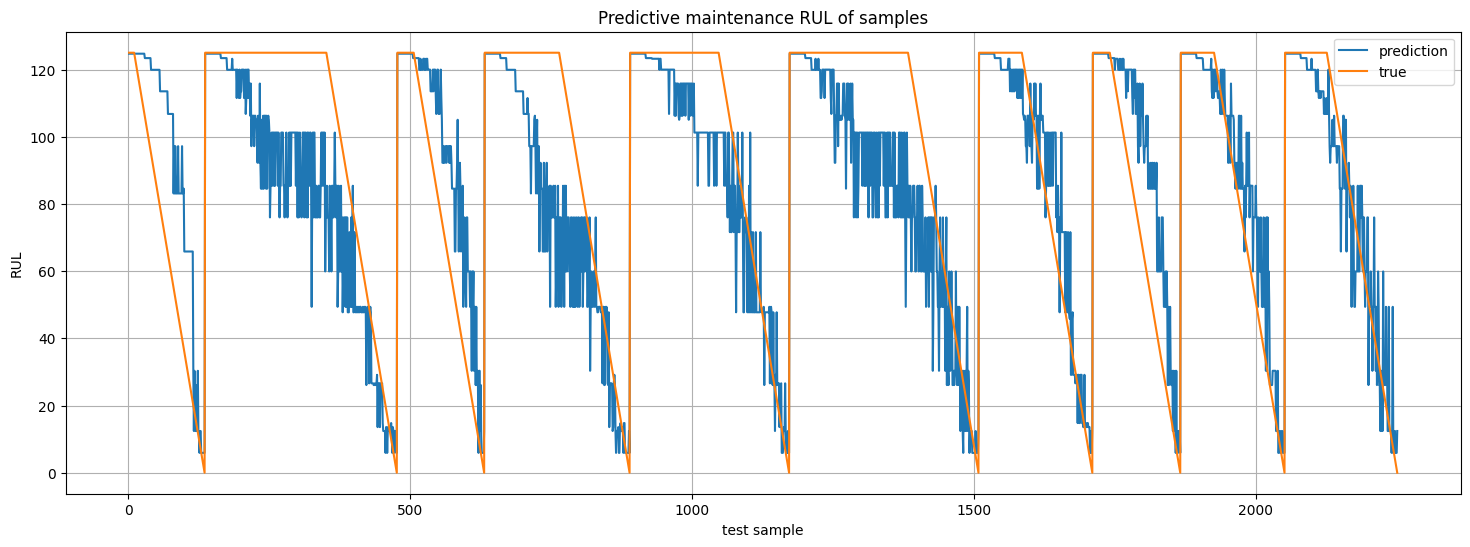

In [304]:
plot_without_cp(y_test, y_pred_dt)

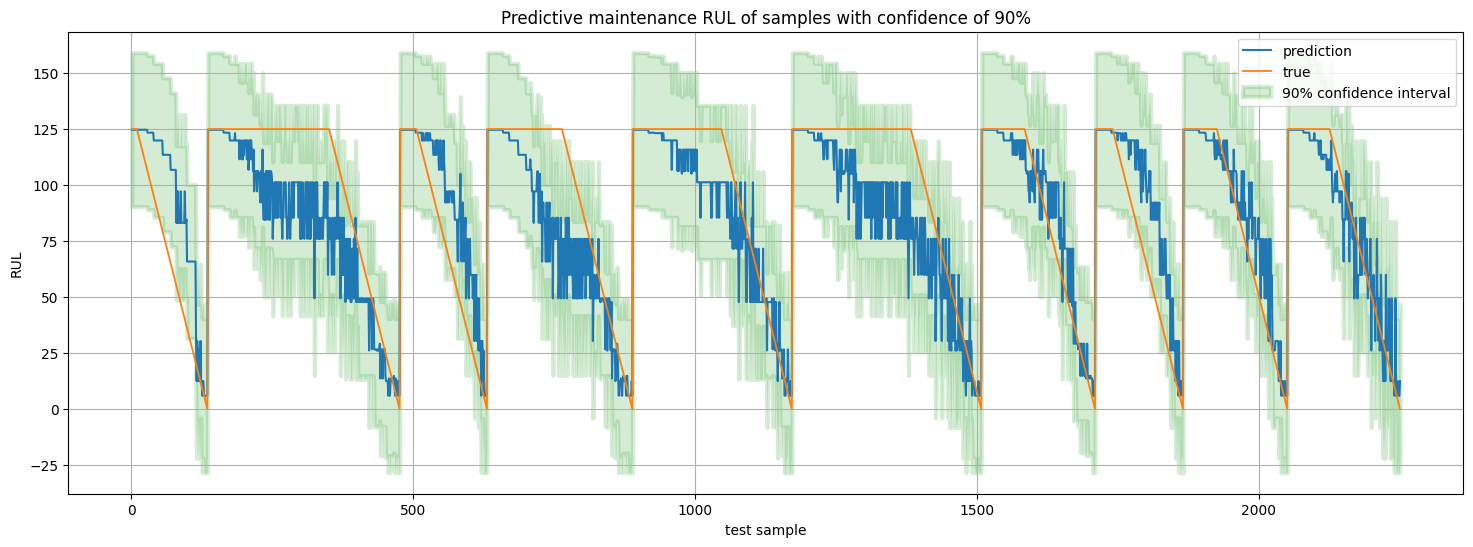

In [305]:
plot_with_cp(y_test, y_pred_dt, y_pis_dt, "90")

In [306]:
gb_model, y_pred = gradient_boost(X_train, y_train, X_test)

In [307]:
y_pred_gb, y_pis_gb = conformal_prediction_crepes(gb_model, 0.1, X_cal, y_cal, X_test)

[123.65243657 124.36580261 123.0167566  ...   5.5936828    4.64027041
   1.81370191]


In [308]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred_gb)

0.7913057607097904

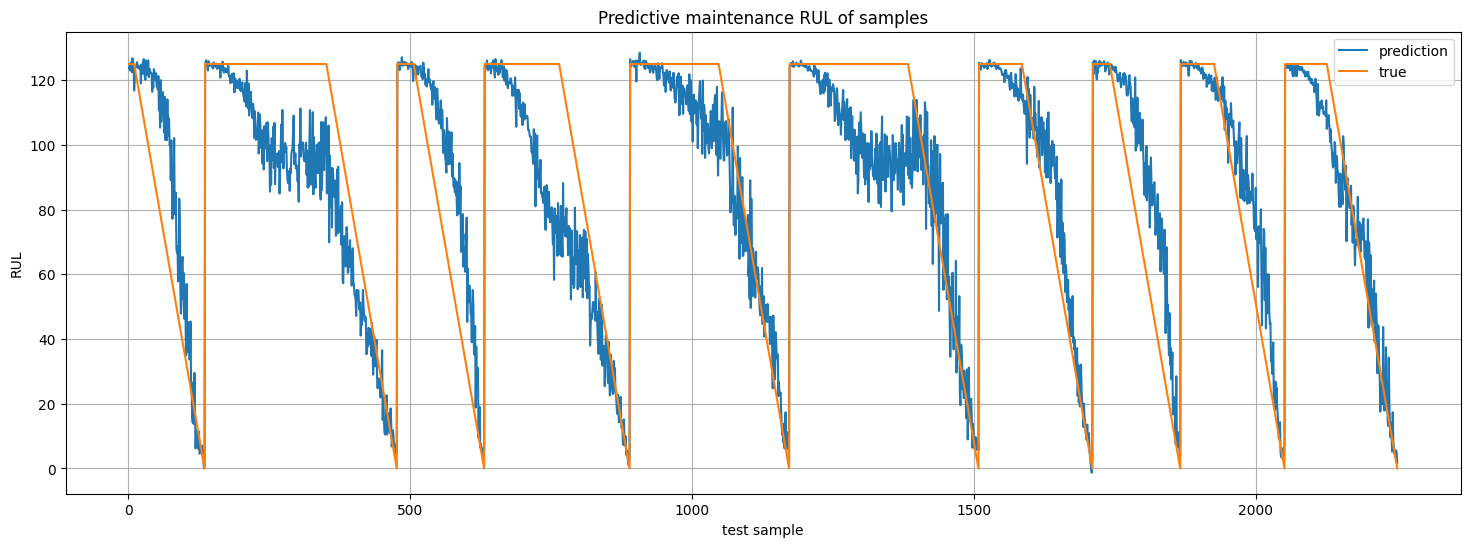

In [309]:
plot_without_cp(y_test, y_pred_gb)

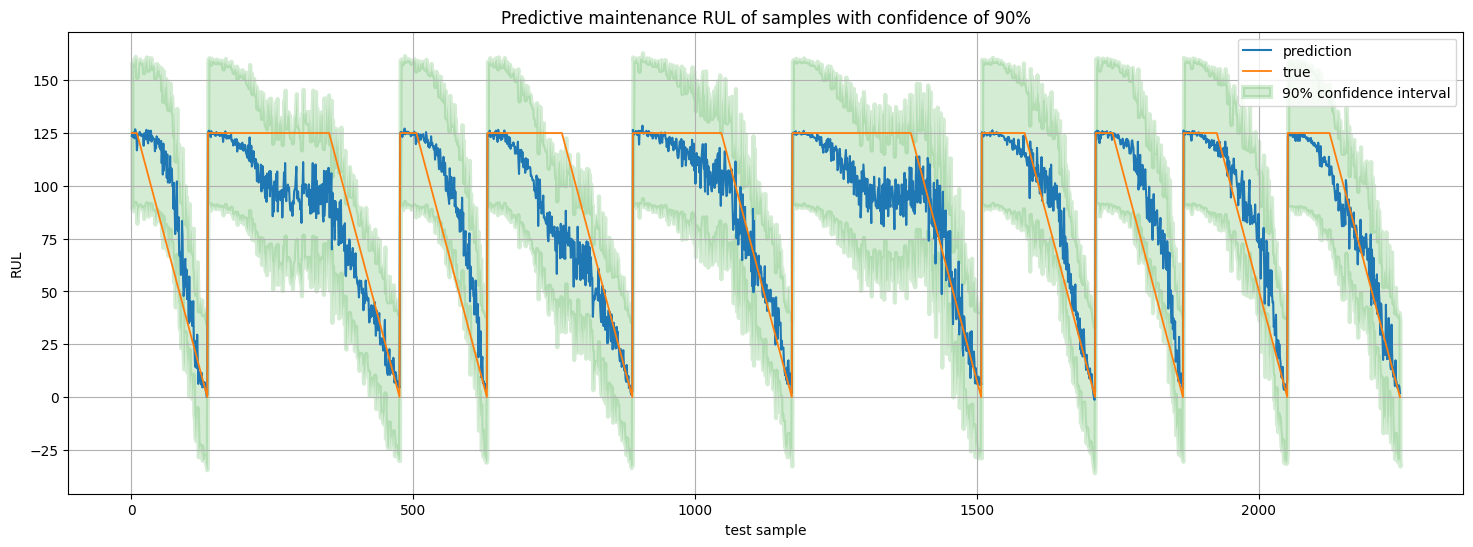

In [310]:
plot_with_cp(y_test, y_pred_gb, y_pis_gb, "90")

In [311]:
# y_pred_gb_mondrian, y_pis_gb_mondrian = conformal_prediction_crepes_mondrian(gb_model, 20, X_cal, y_cal, X_test)

In [312]:
# from sklearn.metrics import r2_score
# r2_score(y_test, y_pred_gb_mondrian)

In [313]:
# plot_with_cp(y_test, y_pred_gb_mondrian, y_pis_gb_mondrian, "90")

# LSTM

In [314]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [315]:
df = pd.read_csv('lstm_data.csv').drop('Unnamed: 0', axis=1)
df.head()

,engine,cycle,setting_1,setting_2,(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Bypass Ratio),(Bleed Enthalpy),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,125
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,125
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,125
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,125
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,125


In [316]:
df_train = df[df["engine"]<=80]#.drop(['engine','cycle'], axis=1)
df_cal = df[(df["engine"]>80)&(df["engine"]<=90)]#.drop(['engine','cycle'], axis=1)
df_test = df[(df["engine"]>90)]#.drop(['engine','cycle'], axis=1)

In [317]:
df_test.head()

,engine,cycle,setting_1,setting_2,(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Bypass Ratio),(Bleed Enthalpy),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),RUL
18380,91,1,-0.0002,-0.0001,643.41,1587.82,1411.03,21.61,554.53,2388.08,9054.59,47.69,521.44,2388.11,8.4351,393,38.77,23.2860,125
18381,91,2,-0.0034,-0.0001,642.74,1584.56,1405.48,21.61,552.66,2388.15,9057.63,47.62,521.16,2388.09,8.4032,393,38.65,23.3206,125
18382,91,3,0.0011,0.0001,642.61,1593.05,1409.55,21.61,553.16,2388.13,9059.80,47.49,521.41,2388.18,8.4361,392,39.04,23.2637,125
18383,91,4,0.0011,0.0005,643.28,1594.84,1409.82,21.61,553.26,2388.12,9051.02,47.48,521.30,2388.11,8.4591,393,38.93,23.3402,125
18384,91,5,-0.0035,-0.0003,643.03,1593.76,1406.69,21.61,553.24,2388.15,9053.33,47.49,521.45,2388.15,8.4754,392,39.02,23.3241,125


In [318]:
features_col_name = (np.array(df_train.columns.tolist()[:-1])).tolist()
target_col_name = (np.array(df_train.columns.tolist()[-1])).tolist()

In [319]:
len(features_col_name)

18

In [320]:
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler()
df_train[features_col_name]=sc.fit_transform(df_train[features_col_name])
df_test[features_col_name]=sc.transform(df_test[features_col_name])
df_cal[features_col_name]=sc.transform(df_cal[features_col_name])

C:\Users\R\AppData\Local\Temp\ipykernel_14832\1732614496.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[features_col_name]=sc.fit_transform(df_train[features_col_name])
C:\Users\R\AppData\Local\Temp\ipykernel_14832\1732614496.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[features_col_name]=sc.transform(df_test[features_col_name])
C:\Users\R\AppData\Local\Temp\ipykernel_14832\1732614496.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [321]:
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    # id_df=df_zeros.append(id_df,ignore_index=True)
    id_df = pd.concat([df_zeros, id_df], ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)


# function to generate labels
def gen_label(id_df, seq_length, seq_cols,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    # id_df=df_zeros.append(id_df,ignore_index=True)
    id_df = pd.concat([df_zeros, id_df], ignore_index=True)

    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [322]:
# timestamp or window size
seq_length = 50
seq_cols = features_col_name

In [323]:
seq_length
seq_cols
df_train.shape

(16138, 19)

In [324]:
X_Train=gen_sequence(df_train, seq_length, seq_cols)
print(X_Train.shape)
# generate y_train
y_train=gen_label(df_train, 50, seq_cols,'RUL')
print(y_train.shape)

(16137, 50, 18)
(16137,)


In [325]:
X_Cal=gen_sequence(df_cal, seq_length, seq_cols)
print(X_Cal.shape)
# generate y_train
y_cal=gen_label(df_cal, 50, seq_cols,'RUL')
print(y_cal.shape)

(2241, 50, 18)
(2241,)


In [326]:
X_Test=gen_sequence(df_test, seq_length, seq_cols)
print(X_Test.shape)
# generate y_train
y_test=gen_label(df_test, 50, seq_cols,'RUL')
print(y_test.shape)

(2250, 50, 18)
(2250,)


In [327]:
X_train =X_Train
X_test = X_Test
y_train =y_train
y_test = y_test

In [328]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import sklearn

def fit_model(X_Train, y_train, X_Test, y_test):
    model = Sequential([
        layers.LSTM(128, input_shape = (X_Train.shape[1], X_Train.shape[2]), return_sequences=True, activation = "tanh"),
        layers.LSTM(64, activation = "tanh", return_sequences = True),
        layers.LSTM(32, activation = "tanh"),
        layers.Dense(96, activation = "relu"),
        layers.Dense(128, activation = "relu"),
        layers.Dense(1)
    ])
    model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
    # callback = tf.keras.callbacks.LearningRateScheduler( verbose = 1)
    model.fit(X_Train, y_train, epochs = 20,
                    validation_data = (X_Test, y_test),
                    # callbacks = callback,
                    batch_size = 128, verbose = 2)
    
    y_pred = model.predict(X_Test)

    return model, y_pred

In [329]:
lstm_model, rul_pred  = fit_model(X_train, y_train, X_test,y_test)

Epoch 1/20
127/127 - 24s - loss: 3915.7964 - val_loss: 1720.7329 - 24s/epoch - 188ms/step
Epoch 2/20
127/127 - 19s - loss: 1743.5364 - val_loss: 1726.4078 - 19s/epoch - 148ms/step
Epoch 3/20
127/127 - 19s - loss: 1745.1603 - val_loss: 1709.7241 - 19s/epoch - 148ms/step
Epoch 4/20
127/127 - 19s - loss: 1027.7329 - val_loss: 690.3385 - 19s/epoch - 150ms/step
Epoch 5/20
127/127 - 19s - loss: 435.2008 - val_loss: 622.4230 - 19s/epoch - 149ms/step
Epoch 6/20
127/127 - 19s - loss: 392.3864 - val_loss: 600.1470 - 19s/epoch - 147ms/step
Epoch 7/20
127/127 - 19s - loss: 370.1137 - val_loss: 569.2057 - 19s/epoch - 153ms/step
Epoch 8/20
127/127 - 20s - loss: 337.4256 - val_loss: 532.1860 - 20s/epoch - 160ms/step
Epoch 9/20
127/127 - 19s - loss: 244.6747 - val_loss: 242.9495 - 19s/epoch - 152ms/step
Epoch 10/20
127/127 - 22s - loss: 187.0240 - val_loss: 218.6245 - 22s/epoch - 170ms/step
Epoch 11/20
127/127 - 21s - loss: 179.9789 - val_loss: 200.2564 - 21s/epoch - 164ms/step
Epoch 12/20
127/127 - 2

In [339]:
from sklearn.metrics import r2_score, mean_squared_error
r2_score(y_test, rul_pred)

0.8542910766513447

In [331]:
mean_squared_error(y_test,rul_pred,squared=False)

15.754074587352825

In [332]:
y_pred = lstm_model.predict(X_Test)

71/71 [==============================] - 2s 28ms/step


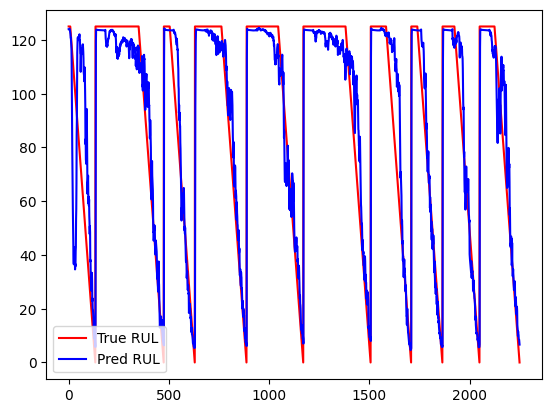

In [333]:
# Plot true and predicted RUL values
plt.plot(y_test, label = "True RUL", color = "red")
plt.plot(y_pred, label = "Pred RUL", color = "blue")
plt.legend()
plt.show()

In [334]:
def conformal_prediction_crepes(model, alpha, X_cal, y_cal, X_test):
  #Standard conformal regressors
  cr_std = ConformalRegressor()
  y_hat_cal = model.predict(X_cal)
  residuals_cal = y_cal - y_hat_cal
  cr_std.fit(residuals=residuals_cal)
  y_hat_test = model.predict(X_test)
  print(y_hat_test)

  # intervals = np.zeros((y_hat.shape[0], 2))
  # intervals[:, 0] = y_hat - alpha


  intervals = cr_std.predict(y_hat=np.squeeze(y_hat_test)[0:2241], confidence=1-alpha)
  # intervals = np.squeeze(intervals)

  return y_hat_test, intervals

In [335]:
intervals

array([[ 69.06 , 179.836],
       [ 69.386, 180.162],
       [ 69.392, 180.168],
       ...,
       [-50.232,  60.544],
       [-52.352,  58.424],
       [-52.59 ,  58.186]])

In [336]:
y_hat_test

array([124.448, 124.774, 124.78 , ...,   5.156,   3.036,   2.798])

In [337]:
y_pred_lstm, y_pis_lstm = conformal_prediction_crepes(lstm_model, 0.1, X_Cal, y_cal, X_test)

71/71 [==============================] - 2s 26ms/step
[[123.98776  ]
 [124.00251  ]
 [124.04249  ]
 ...
 [  8.457867 ]
 [  7.4906654]
 [  6.6549   ]]


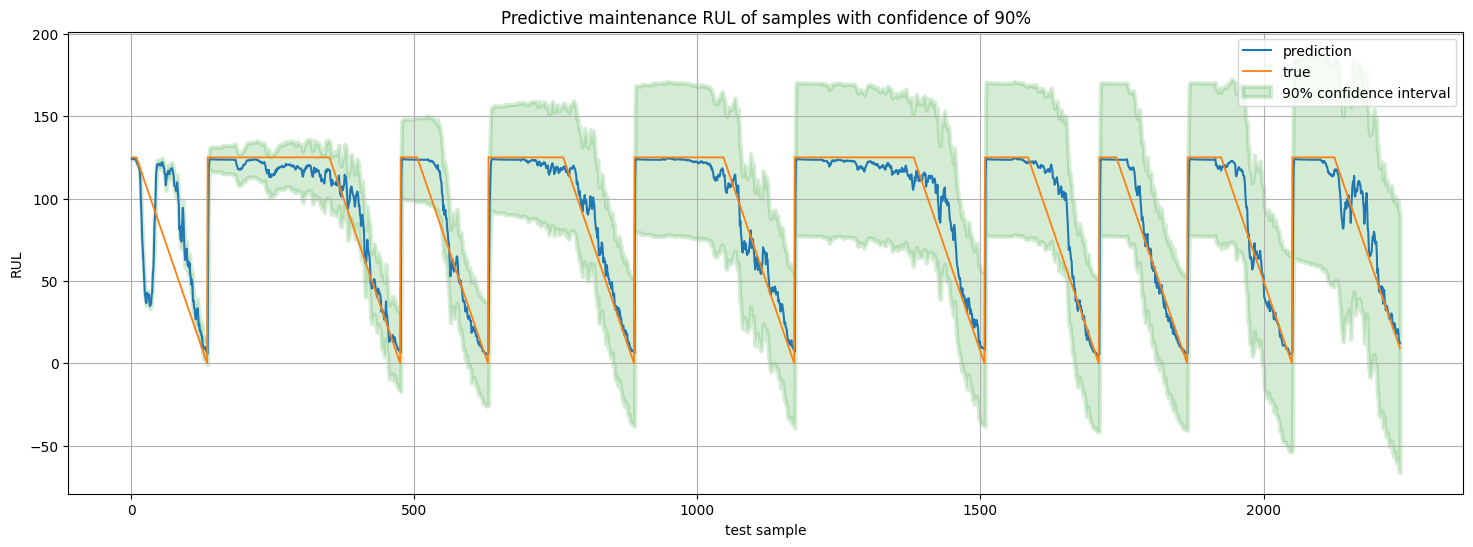

In [345]:
plot_with_cp(y_test[0:2241], y_pred_lstm[0:2241], y_pis_lstm[0:2241], "90")